# Contenidos
* [1. Modelos lineales generalizados (MLG)](#1.-Modelos-lineales-generalizados-%28MLG%29)
	* [1.1 Regresión lineal simple](#1.1-Regresión-lineal-simple)
	* [1.2 Modificando los datos antes de muestrear](#1.2-Modificando-los-datos-antes-de-muestrear)
	* [1.3 Cambiando el método de muestreo](#1.3-Cambiando-el-método-de-muestreo)
	* [1.4 Verificación de las predicciones del _a posteriori_](#1.4-Verificación-de-las-predicciones-del-_a-posteriori_)
	* [1.5 Interpretando el _a posteriori_](#1.5-Interpretando-el-_a-posteriori_)
	* [1.6 Coeficiente de correlación de Pearson](#1.6-Coeficiente-de-correlación-de-Pearson)
	* [1.7 Regresión lineal robusta](#1.7-Regresión-lineal-robusta)
	* [1.8 Regresión lineal jerárquica](#1.8-Regresión-lineal-jerárquica)
	* [1.9 Regresión polinomial](#1.9-Regresión-polinomial)
		* [1.9.1 Polinomios de grado ¿infinito?](#1.9.1-Polinomios-de-grado-¿infinito?)
	* [1.10 Para seguir leyendo](#1.10-Para-seguir-leyendo)


In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from plot_post import plot_post

# 1. Modelos lineales generalizados (MLG)

En el presente capítulo comenzaremos a ver una familia de modelos ampliamente usados en estadística, lo que se conoce como modelo lineal generalizado. Este modelo es la base de métodos como la regresión lineal, regresión múltiple, regresión logística y métodos muy conocidos entre los frecuentistas como el _t-test_, ANOVA, etc.

Todos estos modelos responden a la pregunta general como varía $y$ cuando varío $x$. La variable $y$ suele recibir el nombre de variable independiente, predicha o respuesta. Mientras que la variable $x$ recibe el nombre de variable independiente o predictora. Por ejemplo si queremos predecir el peso de una persona a partir de su edad, el peso será la variable independiente y la edad la dependiente, pero esos roles se invertirán si en cambio predecimos la edad a partir del peso. La razón del nombre independiente (o predictora) es que el valor de esa variable no es predicho por el modelo si no que es establecido desde afuera del modelo, en otras palabras es una entrada (_input_) del modelo y no un resultado. Hay que tener en claro que cuando hablamos de dependencia es por que **en nuestro modelo** hacemos que una variable dependa de la otra, pero esto no quiere decir, necesariamente, que exista una relación causal entre las variables. Es decir, usando un MLG lo único que se puede llegar a establecer es la existencia de una relación entre las variables, y por lo tanto la posibilidad de predecir una variable midiendo la otra. Pero hay que dejar en claro que estamos hablando de correlación entre variables no de relación causa-efecto. Es decir dependiendo del diseño experimental un MLG podrá ser usado para establecer una relación causa-efecto entre variables o solo el grado de correlación entre variables.

## 1.1 Regresión lineal simple

Lo más probable es que ustedes ya hayan tenido contacto con lo que puede considerarse la base de todos los MLG, la regresión lineal simple:
    
$$y_i = \alpha + \beta x_i $$

En este modelo $x$ se conoce como variable independiente (o variable predictora) e $y$ se conoce como variable dependiente (o variable predicha).  $\beta$ es la pendiente e indica el cambio en $y$ por unidad de cambio de $x$, $\alpha$ indica el valor de $y_i$ para cuando $x_i=0$ y gráficamente representa el punto en que la linea intercepta a la ordenada al origen.

A fin de resolver este problema suele ser conveniente escribir esta ecuación de forma matricial. Que de forma resumida se escribe como

$$Y = \beta X$$

y de forma expandida es

$$  \begin{bmatrix}y_0 & y_1 & y_2 & y_n  \end{bmatrix} = \begin{bmatrix} \beta_0 & \beta_1 \end{bmatrix} \begin{bmatrix}1 & 1 & 1 & 1 \\ x_0 & x_1 & x_2 & x_n \end{bmatrix} $$

donde $\beta$ y $X$ se multiplican según el producto matricial, que da como resultado:

$$ Y = \begin{bmatrix}\beta_0 1 + \beta_1 x_0 & \beta_0 1 + \beta_1 x_1 & \beta_0 1 + \beta_1 x_2 & \beta_0 1 + \beta_1 x_n  \end{bmatrix}$$

$\beta$ es un vector de coeficientes (el primer elemento es la ordenada al origen y el segundo la pendiente). $X$ es una matriz de datos que tiene columnas como $n$ observaciones, y tiene una fila más que variables (en la regresión simple hay una sola variable por eso arriba la matriz $X$ tiene dos columnas). La primer fila esta siempre llena de 1 y las siguientes filas (solo una en el caso de la regresión simple) contiene los valores observados para las variables predictoras.

Escrita de esta forma se puede aplicar lo que se conoce ecuación normal y resolver el problema, es decir encontrar los valores de $\alpha$ y $\beta$, de forma muy eficiente. Cada vez que ustedes calcularon el ajuste a una recta con algún _software_, lo más probable es que internamente el _software_ haya resuelto la ecuación normal. Este método devuelve los valores para $\alpha$ y $\beta$ que producen el menor error cuadrático medio entre los valores observados $y$ y los valores predichos de $y$ para cada valor de $x$. Es por ello que el método recibe el nombre de _ajuste por mínimos cuadrados_. Formulado de esa manera estamos frente a un problema de optimización, es decir queremos encontrar el conjunto de coeficientes que minimizen una función de error.

La optimización no es la única forma de resolver problemas. Este mismo problema se puede pensar de forma probabilística (Bayesiana). Formular el problema bajo esta perspectiva nos permite obtener los mejores valores para los parámetros $\alpha$ y $\beta$ (lo mismo que la optimización) junto con una estimación de la incerteza con la que conocemos esos parámetros.

Una ventaja adicional de esta aproximación Bayesiana es que nos permitirá adaptar fácilmente la regresión lineal a modelos que no asumen normalidad o que contienen más parámetros o, en general, que se adaptan mejor a nuestros problemas. Entonces, la regresión lineal simple expresada probabilísticamente queda como:

$$ Y \sim \mathcal{N}(\mu=\alpha + \beta X, \sigma=\epsilon) $$

Es decir los datos $Y$ son generados como una distribución Gaussiana con media $\alpha + \beta X$ y desviación estándar $\epsilon$.

Dado que desconocemos los valores de $\alpha$, $\beta$ y $\epsilon$ debemos fijar _a prioris_, una posibilidad serían los siguientes.

$$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) $$
$$\epsilon \sim U(0, h_{\epsilon}) $$

Si lo que se intenta es usar un _a priori_ ligeramente informativo para $epsilon$ la distribución uniforme con $h_{\epsilon}$, fijado en un valor _grande_ como 10. O más general 10 o 100 veces el valor de la desviación estándar de lo datos, esto es suficiente para garantizar que el _a priori_ tendrá un efecto prácticamente nulo sobre la inferencia (si eso es lo que se pretende), en ese caso obtendremos exactamente los mismos valores para los coeficientes que si hubiésemos usado el método de mínimos cuadrados. Otra alternativa para _a prioris_ ligeramente informativos es usar una distribución Media-Cauchy. Es decir, una distribución t con $\nu=1$ y restringida a valores positivos, con una valor del parámetro _escala_ alto respecto de los datos (pero sin irse de escala). Es uso de la distribución Media-Cauchy da resultados más robustos cuando la cantidad de datos es pequeña (comparado con la distribución uniforme). Si se cuenta con mayor información sobre los posibles valores de la desviación standard entonces puede ser útil usar una distribución gamma (parametrizada según la media y la desviación estandar de forma que sea más intuitiva interpretarla).

<img alt="regresión_lineal_simple" src="imagenes/MLG_base.png", width=300>

En todos los siguientes ejemplos usaremos _a prioris_ ligeramente informativos. Recordemos que en problemas reales es posible que contemos con información útil que nos permita usar _a prioris_ algo más informativos. De hecho, aún sin tener mucha información en muchos problemas es posible saber, por ejemplo, el signo que deberá tener la pendiente aún sin haber observado los datos.

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
# y = a + b*x + e
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# podemos centrar los datos antes de correr
#x = x - x.mean()
# o también podes estandarizar los datos
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

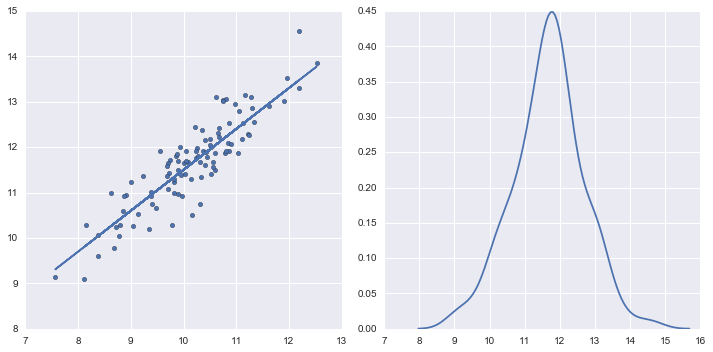

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x, y)
plt.plot(x, y_real)
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.tight_layout()

In [5]:
with pm.Model() as modelo:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=50)

    y_pred = pm.Normal('y_pred', mu=alpha + beta * x, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(10000, step, start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 3.2 sec

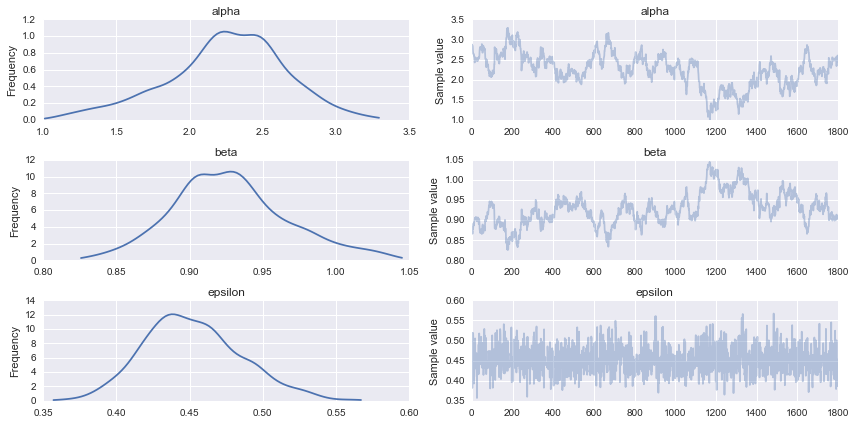

In [6]:
burnin = 1000
thinin = 5
cadena = trace[burnin::thinin]
varnames = ['alpha', 'beta', 'epsilon']
pm.traceplot(cadena, varnames);

In [7]:
pm.df_summary(cadena)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.248994,0.404257,0.038874,1.331755,2.970495
beta,0.927840,0.039839,0.003832,0.851310,1.012868
epsilon_interval,-4.699246,0.073763,0.002169,-4.842711,-4.553621
epsilon,0.452201,0.033257,0.000990,0.390916,0.520616


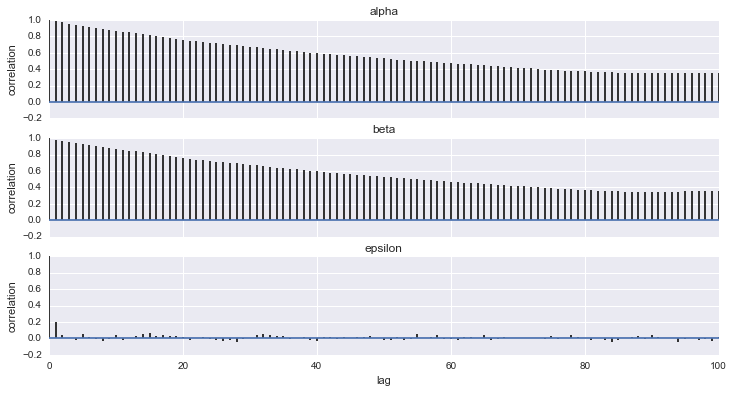

In [8]:
pm.autocorrplot(cadena, varnames);

## 1.2 Modificando los datos antes de muestrear

En el ejemplo anterior la autocorrelación para $\alpha$ y $\beta$ es muy alta y por lo tanto el número efectivo de muestras es muy bajo comparado con el número de pasos del MCMC. Claramente el muestreo es malo, pero ¿A qué se debe este mal desempeño?

Todas las posibles rectas que ajusten los datos deben pasar por el punto medio de $x$ y el punto medio de $y$. Alrededor de ese punto al aumentar la pendiente la ordena al origen deberá disminuir y viceversa. Esta correlación puede hacer que el espacio de los valores más plausibles (que es lo que debemos muestrear) sea una "diagonal". Algo como lo siguiente:

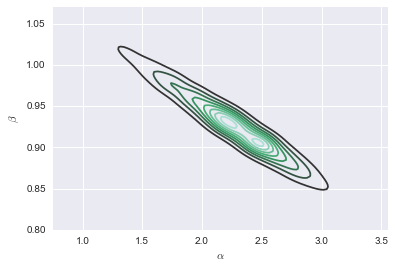

In [9]:
sns.kdeplot(cadena['alpha'], cadena['beta'])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$');

Para algoritmos como Metropolis-Hastings esto puede ser problemático. Ya que la mayoría de las propuestas serán rechazadas y los valores aceptados estarán fuertemente correlacionados entre si. Imaginen en la figura anterior tener que moverse de una punta al centro de la elipse. Para moverse van alternando entre un paso en $\alpha$ y uno en $\beta$, queda claro que la única forma de moverse por espacios de alta probabilidad es en zig-zag, un pequeño paso en $\alpha$ seguido de un pequeño paso en $\beta$, es decir la convergencia es lenta y cada nuevo paso no puede estar muy lejos del anterior (está correlacionado con el anterior). Este problema aumenta a medida que aumentan las variables/dimensiones del problema. A medida que aumentan las dimensiones disminuye el cociente entre el _volumen_ que corresponde a posiciones de baja probabilidad y el volumen total del espacio muestreable.

Una solución es centrar los datos en $X$, es decir a cada punto $X_i$ restarle la media  para todos los puntos $\bar{X}$. 

$$X^* = X - \bar{X}$$

Como resultado el centro de $X^*$ será 0, es decir el punto alrededor del cual se mueve la recta al cambiar la pendiente será alrededor de la ordenada al origen, por lo que el espacio a muestrear es ahora mas "circular" o menos correlacionado.

El centrar las variables, no solo se hace por razones computacionales. Hay casos en que ayuda a la interpretación de los resultados. Si los datos no están centrados la ordenada al origen es el valor de $Y$ para cuando $X$ vale cero, no en todos los casos esta interpretación  tiene sentido, por ejemplo si las variables fueran peso y altura (no tiene sentido hablar de peso ni altura cero). En cambio al centrar las variables la ordenada al origen pasa a ser el valor de $Y$ para el valor medio de $X$. 

En caso de querer expresar el modelo en términos de la variable $X$ no-centrada, una vez terminado el análisis, habrá que corregir el valor de la ordenada al origen de la siguiente forma:

$$\alpha = \alpha^* - \beta^* \bar{X}$$

Esta corrección es el resultado de:

$$X^* = X - \bar{X}$$
$$Y = \alpha^* + \beta^* X^* + \epsilon$$
$$Y = \alpha^* + \beta^*  (X - \bar{X}) + \epsilon$$
$$Y = \alpha^* - \beta^*  \bar{X}+ \beta^*  X  + \epsilon$$

De donde se puede ver que:

$$\alpha = \alpha^* - \beta^*  \bar{X}$$
$$\beta = \beta^*$$

Queda como ejercicio, hacer la prueba de centrar los datos antes de resolver el modelo y revisar como cambia la autocorrelación de los parámetros durante el muestreo, los resultados obtenidos y la correlación entre $\alpha$ y $\beta$.

En muchos casos no solo resulta conveniente centrar los datos si no que puede ser convenientes estandarizarlos es decir

$$X^* = \frac{X - \bar{X}}{X_{sd}}$$
$$Y^* = \frac{Y - \bar{Y}}{Y_{sd}}$$

Una ventaja de estandarizar los datos, es que siempre es posible aplicar los mismos _a prioris_ ligeramente informativos, sin preocuparse por la escala de los datos. Otra ventaja de estadarizar las variables es que un cambio en una unidad es un cambio en una desviación estándar (Z-score), en mucho problemas puede ser más simple hablar de Z-scores que hablar en términos de las unidades originales. Esta idea también se aplica cuando trabajamos con más de una variable predictora (regresión lineal múltiple), en esos es muy probable que cada variable tenga rangos muy distintos estandarizar todas ellas puede facilitar la comparación entre sus efectos. 

Al igual que centrar los datos estandarizarlos también tiene ventajas computacionales. Por lo que es una transformación comúnmente aplicada en estadística y _machine learning_. En muchos problemas el rango para distintas variables puede ser muy diferente, incluso ordenes de magnitud diferente esto hace que muchos algoritmos (no solo Metropolis-Hastings) tengan problemas. Por ej cualquier algoritmo que confíe en computar distancias euclídeas se verá afectado, ya que si no se estandariza, el valor de la distancia dependerá fuertemente de la variable con el rango más amplio, minimizando la contribución de las otras variables al cómputo de la distancia, otro caso corresponde a algoritmos que hacen uso del minimizador _gradiente descendiente_, ya que este algoritmo también deberá zigzagear si las variables no han sido estandarizadas. En definitiva si nuestro método de muestreo tiene problemas es probable que una de las causas sea la falta de estandarización de los datos.

## 1.3 Cambiando el método de muestreo

Por supuesto si el problema reside en el método de muestreo una posible solución es usar otros métodos de muestreo. NUTS (y en general el Hamiltonian Monte Carlo, del cual deriva NUTS) fue diseñado precisamente para resolver este tipo de problemas. Para usar NUTS basta con reemplazar _pm.Metropolis()_ por _pm.NUTS()_. NUTS requiere de un parámetro llamado _scaling_, este parámetro le indica algo así como que tan grande pueden ser los pasos en cada dimensión. Si bien NUTS es capaz de estimar este parámetro es recomendable darle un valor inicial razonable, una forma simple de hacer esto es diciéndole que _scaling_ es igual al resultado de *find\_MAP()*. Un mal valor de _scalling_ puede hacer que NUTS funcione muy lentamente o que incluso se detenga. Al ser NUTS más eficiente que Metropolis suele ser necesario realizar un muestreo con un menor número de pasos, un periodo _burnin_ más corto y un menor _thinning_, todo esto a costa de una mayor costo computacional.

In [11]:
with pm.Model() as modelo_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    
    mu = pm.Deterministic('mu', alpha + beta * x)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.NUTS(scaling=start) 
    trace_n = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 18.6 sec

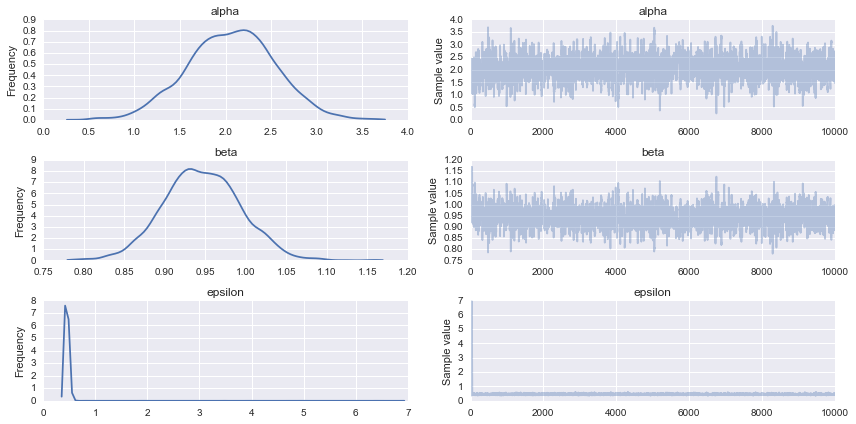

In [13]:
burnin = 0
thin = 1
cadena_n = trace_n[burnin::thin]
pm.traceplot(cadena_n, varnames);

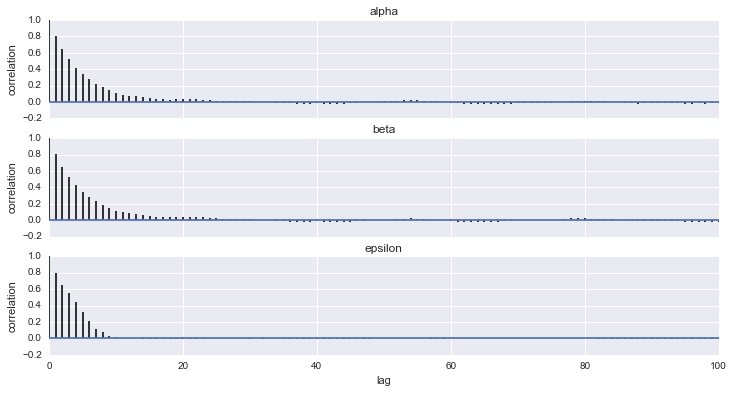

In [14]:
pm.autocorrplot(cadena_n, varnames);

In [15]:
pm.df_summary(cadena_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.064113,0.483974,0.014796,1.098181,2.969571
beta,0.946129,0.047880,0.001482,0.854386,1.038301
epsilon,0.457873,0.132451,0.003558,0.389159,0.526068


## 1.4 Pruebas predictivas _a posteriori_

Las pruebas predictivas _a posteriori_ son una forma de evaluar un modelo. Una vez obtenido el modelo Bayesiano se usa el _a posteriori_ para generar _datos predichos_ $\tilde{y}$, los cuales están condicionados por los valores estimados de $\theta$ y por los datos ya observados $y$. Los datos generados son predictivos ya que son los datos que se esperaría ver por ejemplo en un futuro experimento, es decir son variables no observadas pero potencialmente observables. La prueba consiste en comparar los datos observados con los datos predichos a partir del _a posteriori_. 

$$p(\tilde{y}|y, \theta)$$

Las pruebas predictivas _a posteriori_ son pruebas de autoconsistencia. Este ejercicio nos permite evaluar si el modelo es razonable, la idea general no es determinar si un modelo es _correcto_ o no lo es ya que como dijo George Box _"todos los modelos están equivocados, pero algunos son útiles"_. El grado de confianza en la _verosimilitud_ de los modelos ciertamente es distinta entre practicantes de distintas disciplinas científicas, en disciplinas como física cuando se estudian sistemas relativamente simples bajo condiciones experimentales extremadamente controladas y haciendo uso de _teorías fuertes_, es probable que se le asigne un alto grado de confianza a ciertos modelos. Pero esto no suele ser cierto en disciplinas como ciencias sociales o biología (aunque sospecho que la variabilidad encontrada en biología es muy alta!). En el caso de contar _a prioris_ muy informativos la evaluación de un modelo también puede ser usado para evaluar si los propios datos son razonables, indicando que tal vez sea necesario conseguir nuevos datos o revisar como se obtuvieron los datos o como se procesaron. 

En definitiva la principal utilidad de las pruebas de predictivas _a posteriori_ debería ser el permitirnos dar una segunda mirada, crítica, al modelo y tratar de entender la razón de discrepancias sistemáticas (si las hubiera), estas discrepancias nos pueden llevar a entender mejor los límites del modelo, abandonar el modelo por completo o quizá modificar el modelo.

Si bien se han desarrollado métodos _formales_ o _cuantitativos_ para realizar pruebas predictivas _a posteriori_, una aproximación que suele ser más informativa y simple de interpretar es realizar gráficas.

En PyMC3 una forma de obtener muestras de _datos predichos_ ($\tilde{y}$) es utilizar la función *sample_ppc()*. Por defecto está función devolverá valores predichos para las _variables observadas_ (llamadas en PyMC3 *observed_RVs*).

In [16]:
ppc = pm.sample_ppc(cadena_n, samples=231, model=modelo_n)

En este caso obtuvimos 231 muestras, las muestras tendrán la dimensión de la variable tal cual fue definida en el modelo en nuestro caso *y_pred* era un vector de 100 elementos.

In [17]:
ppc['y_pred'].shape

(231, 100)

Una vez obtenida una muestra de $\tilde{y}$, podemos compararla con los datos $y$, por ejemplo generados gráficos _kde_.

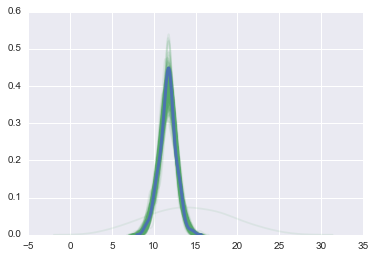

In [18]:
# datos predichos
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.1, c='g');
# datos reales
sns.kdeplot(y, linewidth=3);

## 1.5 Interpretando el _a posteriori_

Como ya vimos para otros casos podemos explorar el _a posteriori_ usando las funciones _traceplot_ y *df_summary* ofrecidas por PyMC3 o podemos usar nuestras propias funciones. Por ejemplo puede ser útil reportar los valores medios de $\alpha$ y $\beta$ y la recta que corresponde a esos valores medios.

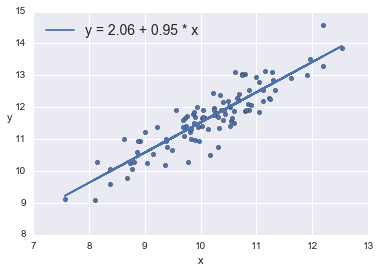

In [19]:
plt.scatter(x, y);
#plt.plot(x, y_real, color='r')
alfa_m = cadena_n['alpha'].mean()
beta_m = cadena_n['beta'].mean()
plt.plot(x, alfa_m + beta_m*x, c='b', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2, fontsize=14);

O podemos hacer algo como la gráfica anterior a la que le agregamos una muestra de rectas semitransparentes tomadas del _a posteriori_, para dar una idea visual de la incertidumbre de nuestra estimación.

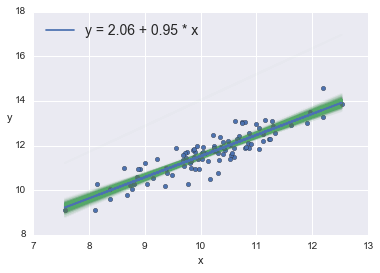

In [20]:
plt.scatter(x, y);
#plt.plot(x, y_real, color='r')

for i in range(0, len(cadena_n['alpha']), 10):
    plt.plot(x, cadena_n['alpha'][i] + cadena_n['beta'][i]*x, c='g', alpha=0.02)
    
plt.plot(x, alfa_m + beta_m*x, c='b', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2, fontsize=14);

O directamente podemos dibujar el HDI (por ejemplo 98%) de la media $\mu$:

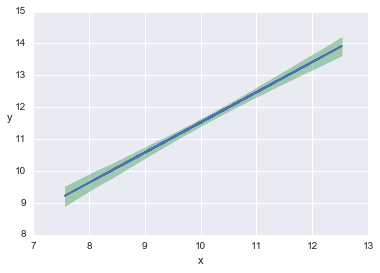

In [21]:
#plt.scatter(x, y);
#plt.plot(x, y_real, color='r')

plt.plot(x, alfa_m + beta_m*x, c='b', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(cadena_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='g', alpha=0.5)

plt.xlabel('x')
plt.ylabel('y', rotation=0);

O podemos graficar el HDI (95 y 50) de los datos predichos $\tilde{y}$, es decir según el modelo donde se espera ver el 95% y el 50% de los valores predichos.

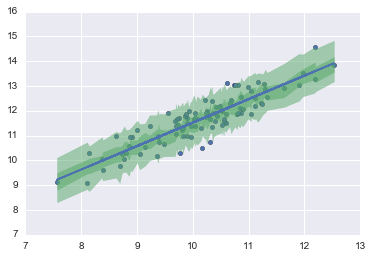

In [22]:
plt.scatter(x, y)
plt.plot(x, alfa_m + beta_m*x, c='b', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='g', alpha=0.5);
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='g', alpha=0.5);

El aspecto _aserrado_ o irregular de la curva debería disminuir a medida que aumente el número de muestras para *y_pred*.

Cuando realizamos una regresión lineal es posible que solo nos interese saber cual es el cambio de la variable dependiente cuando cambiamos la independiente. En ese caso deberemos mirar el valor de $\beta$, recordemos que el _a posteriori_ contiene toda la información posible sobre $\beta$ dado el modelo y los datos.

Podría ser que nos interese determinar si los valores de la pendiente son o no compatibles con algún valor, por ejemplo 0 si lo que intentamos determinar es si existe algún efecto de una variable sobre la otra, o algún otro valor en particular como 0.9. O si la pendiente es positiva o negativa, ya que hay estudios previos que indican una u otra posibilidad. Como vimos anteriormente esto se puede hacer reportando directamente el _a posteriori_ o reportando el HDI junto con la media o el modo, o haciendo uso de la ROPE.

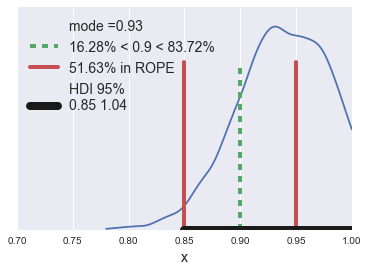

In [23]:
plot_post(cadena_n['beta'], xlab='x', comp_val=.9, ROPE=[0.85,.95])
plt.xlim(0.7, 1);

## 1.6 Coeficiente de correlación de Pearson

Muchas veces al realizar regresiones lineales, además de los parámetros de la recta, nos interesa saber que tan correlacionadas están dos variables. El coeficiente de correlación de Pearson ($r$) es una medida de cuan lineal es la relación entre dos variables, cuando este valor se acerca a ±1 la relación es perfectamente lineal, y cuando $r=0$ no hay linearidad entre las variables. Es muy fácil que se suela confundir a $r$ con la pendiente de la recta $\beta$. La pendiente es una medida del cambio esperado en $y$ por unidad de cambio en $x$. 

En el siguiente gráfico se observan varios conjuntos de puntos y se indica el coeficiente de correlación. En la primer fila se puede ver que $r$ refleja la magnitud de la linearidad entre variables y la dirección (positiva o negativa). En la segunda fila se ve que $r$ no es necesariamente igual a la pendiente, el conjunto de puntos en el centro tiene pendiente 0 pero coeficiente de correlación indefinido (por que la varianza de $y$ es nula). En la última fila se puede observar que $r$ no es capaz de medir relaciones no lineales entre variables.
 
<a href="https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient">
<img border="0" alt="Correlación" src="imagenes/Correlación.png"></a>

Parte de la confusión se origina en que la pendiente y el coeficiente de correlación de Pearson están relacionados como muestra la siguiente expresión:
    
$$r = \beta \frac{sd(X)}{sd(Y)}$$

Entonces podemos decir que la pendiente y el coeficiente de correlación de Pearson serán iguales solo cuando las desviaciones estándar de $X$ e $Y$ sean iguales, por ejemplo cuando los datos estén estandarizados.

El coeficiente de correlación de Pearson $r$ está relacionada con otra cantidad llamada coeficiente de determinación y que es simplemente $r^2$. A continuación se muestran dos formas de obtener $r^2$, en la linea 9 hemos usado la definición dada mas arriba que relaciona $r$ con la pendiente. En este caso las desviaciones estandard las hemos calculado directamente de los datos, pero si fuese necesario se podrían inferir junto con el resto de los parámetros. En las lineas 11-14 se pueden ver otra forma de calcular $r^2$, es probable que estas lineas le resulten familiares para quienes tengan familiaridad con el método de mínimos-cuadrados. $ss_{reg}$ es una medida de la dispersión entre la linea predicha y la media de los datos, es proporcional a la varianza en el modelo (fíjense que la formula es la de una varianza pero sin dividir en la cantidad de observaciones). $ss_{reg}$ es proporcional a la varianza de los datos (solo falta dividir en la cantidad de observaciones). Es por esto que se suele referir al coeficiente de correlación, $r^2$, como la varianza explicada por el modelo.

In [24]:
with pm.Model() as modelo_n:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    rb = pm.Deterministic('rb', (beta*x.std()/y.std())**2)

    y_mean = y.mean()
    ss_reg = pm.sum((mu-y_mean)**2)
    ss_tot = pm.sum((y-y_mean)**2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
       
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_n = pm.sample(10000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 18.6 sec

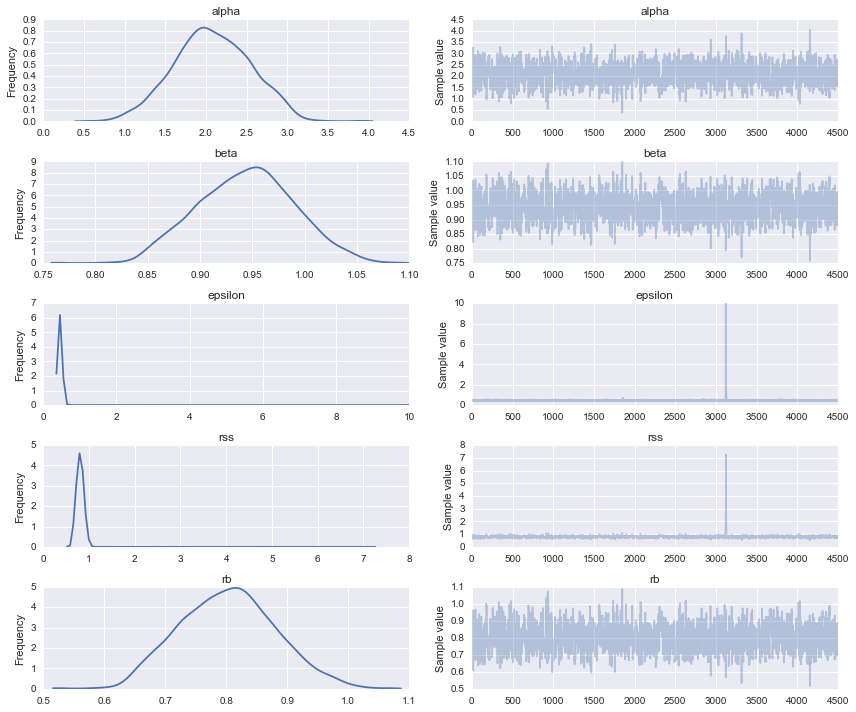

In [25]:
cadena_n = trace_n[1000::2]
varnames = [alpha, beta, epsilon, rss, rb]
pm.traceplot(cadena_n, varnames);

In [26]:
pm.df_summary(cadena_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.082598,0.472470,0.014409,1.232506,3.027703
beta,0.944223,0.046418,0.001399,0.852892,1.030497
epsilon,0.465203,0.290536,0.010431,0.390936,0.526318
rss,0.810477,0.152547,0.005577,0.646598,0.947722
rb,0.802996,0.078716,0.002379,0.645533,0.944736


## 1.7 Regresión lineal robusta

El supuesto de normalidad de la distribución de los errores es un subproducto de una era en donde las computadoras no existían y por lo tanto los cálculos había que hacerlos a mano, por lo tanto las personas buscaban (razonablemente) formas simples de resolver analíticamente los problemas. Hoy en día no suele ser una restricción el no contar con una solución analítica ya que contamos con numerosos métodos numéricos y sobre todo con computadoras para resolverlos sin demasiado esfuerzo. Esto no quiero decir que resolver problemas analíticamente no sea provechoso, solo que en muchos casos es posible otras aproximaciones. La pregunta ¿Son mis datos normales? suele tener como respuesta invariable, NO!, de todas formas los datos suelen ser lo _suficientemente normales_ como para que los métodos que asumen normalidad funcionen bien. 

Como hicimos en el capítulo anterior usaremos la distribución t de Student en vez de la distribución Gaussiana.

<img alt="regresión_lineal_simple" src="imagenes/MLG_regresión_robusta.png", width=500>


Como ejemplo de la robustez que se puede lograr al cambiar la distribución Normal por una t de Student usaremos el tercer grupo de datos del cuarteto de [Anscombe](https://en.wikipedia.org/wiki/Anscombe's_quartet) (quienes no conozcan este cuarteto no dejen de hacer click en el enlace).

In [ ]:
x_3 = np.array([10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0])
y_3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alfa_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alfa_c + beta_c* x_3), label='y ={:.2f} + {:.2f} * x'.format(alfa_c, beta_c));
plt.scatter(x_3, y_3);
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.tight_layout()

In [ ]:
with pm.Model() as modelo_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace_t = pm.sample(5000, step=step, start=start)

In [ ]:
cadena_t = trace_t[::]
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(cadena_t, varnames);

In [ ]:
pm.df_summary(cadena_t, varnames)

In [ ]:
#pm.autocorrplot(cadena_t, varnames);

In [ ]:
plt.scatter(x_3, y_3);
alfa_m = cadena_t['alpha'].mean()
beta_m = cadena_t['beta'].mean()
plt.plot(x_3, alfa_m + beta_m*x_3, c='g', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=0, fontsize=14);

In [ ]:
ppc = pm.sample_ppc(cadena_t, samples=1000, model=modelo_t)

In [ ]:
# datos predichos
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='g');
# datos reales
sns.kdeplot(y_3, linewidth=3);

In [ ]:
plt.scatter(x_3, y_3);
plt.xlabel('x')
plt.ylabel('y', rotation=0)
for i in range(0, len(cadena_t['alpha']), 10):
    plt.plot(x_3, cadena_t['alpha'][i] + cadena_t['beta'][i]*x_3, c='g', alpha=1);

## 1.8 Regresión lineal jerárquica

In [ ]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)

alfa_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(0.9*100, 0.1*100, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alfa_real[idx] + beta_real[idx] * x_m  + eps_real

In [ ]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    #print(stats.linregress(x_m[j:k], y_m[j:k])[:2])
    j += N
    k += N
plt.tight_layout()

In [ ]:
x_centrada = x_m - x_m.mean()

In [ ]:
with pm.Model() as modelo_desagrupado:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centrada, sd=epsilon, nu=nu, observed=y_m)

    # corregimos alfa para que esté en la escala original de los datos
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    step = pm.Metropolis() 
    trace_d = pm.sample(10000, step=step, start=start)

In [ ]:
cadena_d = trace_d[1000::5]
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(cadena_d, varnames);

In [ ]:
#pm.autocorrplot(cadena_d, varnames=[epsilon, nu]);

In [ ]:
pm.df_summary(cadena_d, varnames)

Tenemos dos opciones aumentar la cantidad de datos, que para los datos sintéticos es tan simple como aumentar N (de hecho eso es un buen ejercicio), pero que en la realidad puede ser difícil, engorroso o incluso imposible o podemos hacer un modelo jerárquico.

<img alt="regresión_lineal_simple" src="imagenes/MLG_regresión_robusta_jerarquica.png", width=500>

In [ ]:
with pm.Model() as modelo_agrupado:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=100)
    alpha_tmp_sd = pm.Uniform('alpha_tmp_sd', lower=0.01, upper=100)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=100)
    beta_sd = pm.Uniform('beta_sd', lower=0.01, upper=100)

    
    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    nu0 = pm.Exponential('nu0', 1/29)
    nu = pm.Deterministic('nu', nu0 + 1)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centrada, sd=epsilon, nu=nu, observed=y_m)

    # correjimos alfa para que esté en la escala original de los datos
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    start = pm.find_MAP()
    #step = pm.NUTS(scaling=start) 
    step = pm.Metropolis()
    trace_a = pm.sample(20000, step=step, start=start)

In [ ]:
cadena_a = trace_a[2500::5]
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(cadena_a, varnames);

In [ ]:
pm.df_summary(cadena_a, varnames)

In [ ]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    alfa_m = cadena_a['alpha'][:,i].mean()
    beta_m = cadena_a['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m*x_range, c='g', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    #print(stats.linregress(x_m[j:k], y_m[j:k])[:2])
    j += N
    k += N
plt.tight_layout()

## 1.9 Regresión polinomial

Como ya anticipamos, la regresión lineal simple sirve de base para construir muchos otros modelos. Incluso para construir modelos que ajustan curvas. Una forma de ajustar curvas es mediante la construcción de polinomios que lucen como: 

$$\mu = \beta_0 X^0 + \beta_1 X^1 + \beta_2 X^2 + \beta_3 X^3 ... + \beta_n X^n$$

Esta ecuación muestra un polinomio de grado n. Dentro de este polinomio se encuentra escondida la ecuación de la recta que hemos venido usando, para descubrirla solo hay que hacer que todos los coeficientes $\beta_n$ para $n > 1$ sean igual a cero y obtendremos

$$\mu = \beta_0 + \beta_1 X$$

Por lo tanto el modelo lineal que hemos venido usando hasta ahora puede ser _expandido_ para representar relaciones no lineales!

El modelo polinomial más simple (luego de una constante y de la recta, claro está) es la ecuación de una parábola.

$$\mu = \alpha + \beta_1 X + \beta_2 X^2$$

El tercer término es el que controla la curvatura de la relación. Aún cuando aparece $X$ elevado al cuadrado esta regresión se considera un modelo lineal ya que es lineal respecto de los coeficientes $\alpha$ y $\beta$ (y es por ello que se llama lineal, no por que ajuste lineas rectas!). Quizá la siguiente expresión aclare las cosas (o las empeore), un modelo lineal se puede escribir de forma matricial como:

$$\mu = \beta X$$

donde $\beta$ es un vector de coeficientes de tamaño igual al orden del polinomio más 1 (para una recta seria 2 y para una parábola 3) y $X$ es una matriz de $n \times m$, siendo $n$ la cantidad de observaciones y $m$ de igual tamaño que $\beta$.

Veamos como ajustar este modelo usando el segundo conjunto de datos del cuarteto de Anscombe

In [29]:
x_2 = np.array([ 10.,   8.,  13.,   9.,  11.,  14.,   6.,   4.,  12.,   7.,   5.])
y_2 = np.array([ 9.14,  8.14,  8.74,  8.77,  9.26,  8.1 ,  6.13,  3.1 ,  9.13,
        7.26,  4.74])

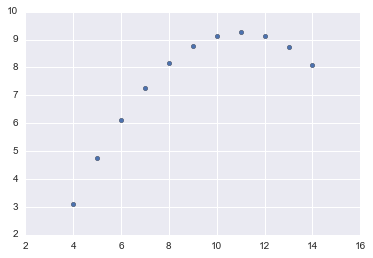

In [30]:
plt.scatter(x_2, y_2);

In [31]:
with pm.Model() as modelo_c:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_c = pm.sample(5000, step=step, start=start)

Applied interval-transform to epsilon and added transformed epsilon_interval to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 17.0 sec

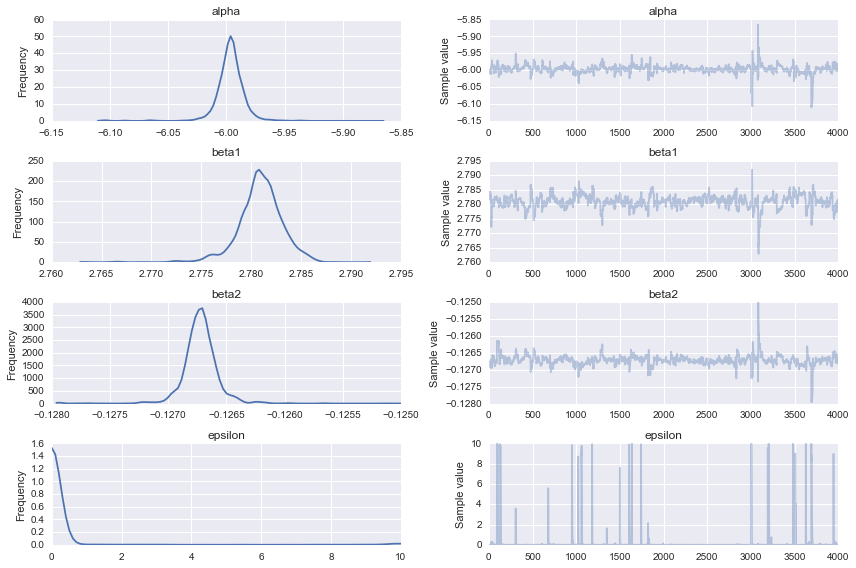

In [33]:
cadena_c = trace_c[1000::]
pm.traceplot(cadena_c, varnames=[alpha, beta1, beta2, epsilon]);

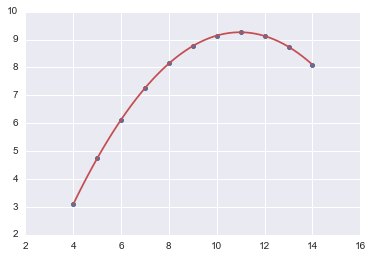

In [34]:
x_p = np.linspace(4, 14, 50)
y_p = cadena_c['alpha'].mean() + cadena_c['beta1'].mean() * x_p + cadena_c['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.plot(x_p, y_p, c='r');

In [35]:
pm.df_summary(cadena_c)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-5.996612,0.013135,0.000826,-6.017623,-5.974901
beta1,2.780914,0.002239,0.000154,2.776970,2.785870
beta2,-0.126723,0.000159,0.000011,-0.126982,-0.126424
epsilon_interval,-7.639347,2.224812,0.124924,-9.225509,-4.549644
epsilon,0.219235,1.313761,0.058468,0.000985,0.104604


Uno de los problemas de la regresión lineal es que la interpretación de los coeficientes puede ser complicada. Por ejemplo para evaluar cuando aumenta $y$ por unidad de aumento de $x$ no basta con el parámetro $\beta_1$ ya que $\beta_2$ tiene un efecto sobre esta cantidad. En el ejemplo anterior $\beta_1$ es positiva indicando una pendiente positiva, pero $\beta_2$ es negativo por lo tanto se contrapone a este aumento, además este _juego de fuerzas_ entre $\beta_1$ y $\beta_2$ depende de $x$. Cuando $x < ~11$ domina la contribución de $\beta_1$ pero para $x > ~11$ la contribución de $\beta_2$ es mayor.

Si la interpretación de los coeficientes es importante (y no solo ajustar la curva) entonces puede ser mejor idea incorporar las relaciones no-lineales siguiendo alguna teoría o modelo más mecanicista del problema que conduzca a un modelo distinto de un polinomio.

### 1.9.1 Polinomios de grado ¿infinito?

Si el modelo lineal es un súbmodelo de un polinomio de grado 2 (o en general de grado $n \ge 2$). Entonces esto quiere decir que un polinomio de grado 2 no solo ajusta curvas más o menos parabólicas, si no que además ajusta puntos que siguen una relación más o menos lineal, en ese caso $\beta_2$ simplemente valdrá cero. Este es un buen momento para dejar de leer y usar el modelo polinomial anterior para ajustar x_3 e y_3 (el tercer conjunto de datos del cuarteto de Anscombe).

Si realmente dejaron de leer e hicieron el ejercicio propuesto habrán comprobado por ustedes mismos que se puede usar un modelo cuadrático para ajustar una recta. Una posible conclusión de este ejercicio es que no habría razón para detenerse en un polinomio de grado 2, si no que deberíamos usar polinomios de grado infinito! Hay al menos dos formas de poner esta idea en práctica:

* La versión ingenua: Como veremos en detalle en el capítulo XX el problema de esta aproximación es que conduce a _sobreajustar_ los datos (_overfitting_). Esto sucede cuando el modelo no solo ajusta (o _aprende_ en términos de _machine learning_) los datos si no que empieza a ajustar también el ruido. Es decir en vez de obtener un modelo que es una buena generalización de los datos obtenemos un modelo que es una buena _particularización_ de los datos, explica tan bien los _detalles_ que no sirve para explicar otros datos similares. En el capítulo  sobre selección de modelos veremos estrategias para modelos que ajusten bien los datos pero sin producir _overfitting_.

* Los modelos no-paramétricos: Todos los modelos Bayesianos que hemos visto hasta ahora son paramétricos. Es decir, nuestro objetivo ha sido dado un modelo y un conjunto de datos determinar los parámetros de ese modelo. El único caso de aproximación no-paramétrica que hemos visto ha sido el KDE (pero que no es Bayesiana), en el KDE por cada nuevo punto que tengamos en los datos se suma una nueva Gaussiana. De forma similar, los modelos Bayesianos no paramétricos no es que carezcan de parámetros si no que el número de parámetros aumenta a medida que aumentan los datos (teóricamente se puede pensar como un modelo con parámetros infinitos). En este curso NO veremos modelos Bayesianos no-paramétricos. Quien tenga interés en seguir leyendo sobre este tema puede buscar información usando los términos Procesos Gaussianos (Gaussian processes) y Procesos de Dirichlet (Dirichlet processes).

## 1.10 Para seguir leyendo

* Más sobre modelos generalizados lineales en:
    * Capítulo 17 de [Doing Bayesian Data Analysis (2 edición)](www.amazon.com/gp/product/0124058884) de John Kruschke.
    * Capítulo 4 de [Statistical Rethinking](https://www.crcpress.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-Stan/McElreath/9781482253443) de Richard McElreath.
    * Capítulos 14 a 17 de [Bayesian Data Analysis](www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954) de Andrew Gelman

* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)
    * Capítulo 9 de [Doing Bayesian Data Analysis (2 edición)](www.amazon.com/gp/product/0124058884) de John Kruschke.
    * Capítulo 12 de [Statistical Rethinking](https://www.crcpress.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-Stan/McElreath/9781482253443) de Richard McElreath.

* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)   


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))